In [1]:
import numpy as np

from sklearn.metrics import classification_report

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import accuracy_score

import time
from typing import List

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [3]:
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

In [4]:
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]

test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]

train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

In [5]:
# запишем сразу нужные нам функции и их производные
# сигмоида
sigmoid = lambda x: 1 / (1 + np.exp(-x))
sigmoid_x = lambda x: sigmoid(x) * (1-sigmoid(x))
# гиперболический тангенс
tanh_x = lambda x: 1 - (np.tanh(x) ** 2)

In [6]:
INPUT_FEATURES = train_dataset.data.shape[1] * train_dataset.data.shape[2]
OUTPUT_FEATURES = 4
BATCH_SIZE = 128
LEARNING_RATE = 0.01
EPOCHS = 5

In [7]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
w1: np.ndarray = np.random.rand(INPUT_FEATURES, OUTPUT_FEATURES) * LEARNING_RATE
b1: float = np.zeros(OUTPUT_FEATURES)
w2: np.ndarray = np.random.rand(OUTPUT_FEATURES, 1) * LEARNING_RATE
b2: float = np.zeros(1)

losses: List[float] = []

for n_epoch in range(EPOCHS):
    
    print(f'Epoch: {n_epoch + 1}')
    
    for x, y in train_loader:
        x = x.view(x.shape[0], -1).numpy()
        y = np.expand_dims(y.numpy(), 1)
        ### КОД СЮДА ###
        # forward
        z1 = np.dot(x, w1) + b1
        a1 = np.tanh(z1)
        
        z2 = np.dot(a1, w2) + b2
        pred = sigmoid(z2)
        
        # рассчет bce
        loss = -np.mean(y*np.log(pred) + (1-y)*np.log(1-pred))

        # не забудьте добавить это значение в массив losses
        losses.append(loss)
        
        # backward
        # Считаем производную BCE, сигмоиды и гиперболического тангенса
        
        dloss_dpred = (-y/pred - (y-1)/(1-pred)) / x.shape[0]
        dpred_dz2 = sigmoid_x(pred)
        da1_dz1 = tanh_x(z1)
        
        # Считаем производные, которые нам нужны по пути к весам
        dloss_dz2 = dloss_dpred * dpred_dz2
        dloss_da1 = np.dot(dloss_dz2, w2.T)
        dloss_dz1 = dloss_da1 * da1_dz1
        dloss_dw2 = np.dot(a1.T, dloss_dz2)

        dloss_db2 = np.mean(dloss_dz2, axis=0)
        dloss_dw1 = np.dot(x.T, dloss_dz1)
        dloss_db1 = np.mean(dloss_dz1, axis=0)
        
        # gradient descent
        w1 -= (dloss_dw1 * LEARNING_RATE)
        w2 -= (dloss_dw2 * LEARNING_RATE)
        b1 -= (dloss_db1 * LEARNING_RATE)
        b2 -= (dloss_db2 * LEARNING_RATE)

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5


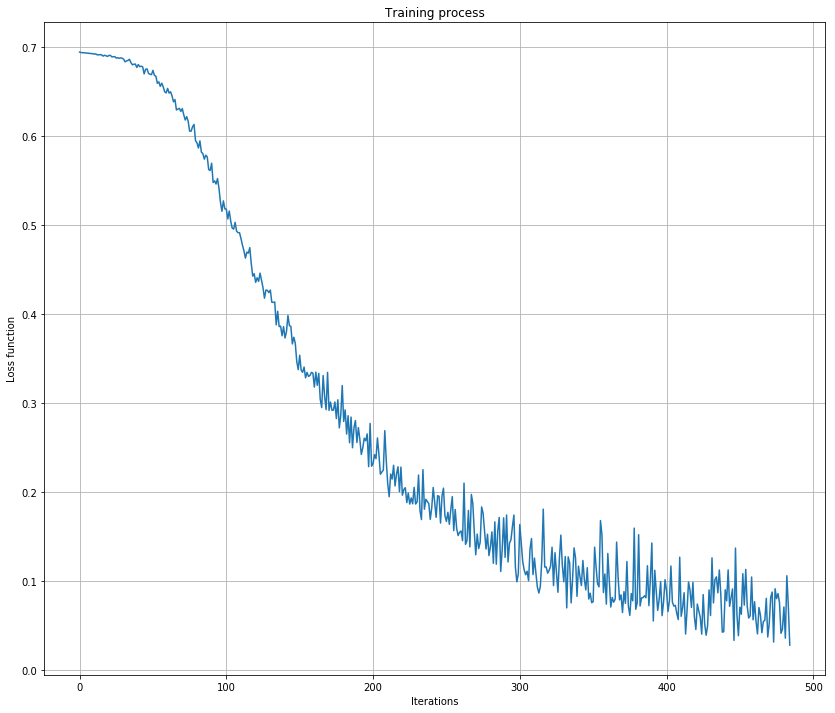

In [9]:
plt.figure(figsize=(14, 12))
plt.plot(losses)
plt.grid()
plt.title('Training process')
plt.xlabel('Iterations')
plt.ylabel('Loss function');